# Yelp Data 

Import the python scientific suite

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import seaborn as sns
import scipy
import pylab

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import linear_model

from collections import defaultdict

# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division
%matplotlib inline
sns.set()
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')

In [2]:
def CountInstance(df, col_name):

    name, counts = np.unique(df[col_name], return_counts = True)
    counts_df = pd.DataFrame(data = {col_name: name, ('n_'+ col_name):counts})
    merged_df = pd.merge(df, counts_df, on = col_name, how = 'left')
    
    return(merged_df)

def TopChains(df, cutoff):
    #
    # Find the top chains
    # include a dataframe with column 'business_name'
    
    name, counts = np.unique(df['name'], return_counts = True)
    counts_df = pd.DataFrame(data = {'name': name, 'counts':counts})
    top_chains = counts_df.sort_values(by = 'counts', ascending = False)
    top_chains.index = range(len(top_chains)) #re-index
    
    return list(top_chains['name'][top_chains['counts'] > cutoff])

def OrderName(df, order_col, order_on):

    ordr = [] #median
    nme = [] #name

    for name in (np.unique(df[order_col])):
        nme.append(name)
        ordr.append(np.mean(df[df[order_col] == name][order_on].dropna()))

    order = list(pd.DataFrame([nme,ordr]).T.sort_values(by = 1)[0])
    
    return(order)

In [3]:
file_dir = '/Volumes/1TB_BAY/yelp_dataset_challenge_academic_dataset/'

r = pd.read_csv(file_dir + 'review_without_text_year.csv')
b = pd.read_csv('yelp_business_with_neighborhood.csv')
s = pd.read_csv('static_stats.csv')
u = pd.read_csv(file_dir + 'yelp_academic_dataset_user.csv')

/Users/Franklin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,5,30,50,61,63,80,87,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
b = CountInstance(b, 'z_hood') #add number of businesses per neighborhood column
r = CountInstance(r, 'business_id')  #add number of reviews per business column

In [5]:
min_business_per_neighborhood = 2
min_reviews_per_business = 2
min_stores_per_chain = 50
min_reviews_per_user = 5

bf = b[(b['n_z_hood'] >= min_business_per_neighborhood)] #omit neighborhoods with less than 
tc = TopChains(bf, min_stores_per_chain) #compute the top chains
bf = bf[bf['name'].isin(tc)] #filter to just the top chains
rf = pd.merge(r, bf, on = 'business_id', how = 'inner') #find just these reviews
rf = rf[(rf['n_business_id'] >= min_reviews_per_business)]

uf = u[(u['review_count'] >= min_reviews_per_user)] #users filtered by min reviews per user
rfu = pd.merge(rf, uf, on = 'user_id', how = 'inner') #reviews written by "good" users

rs = pd.merge(rfu, s, on = 'z_hood', how = 'inner') #dataframe of reviews with zhvi data
bs = pd.merge(bf, s, on = 'z_hood', how = 'inner') #dataframe of business with zhvi data

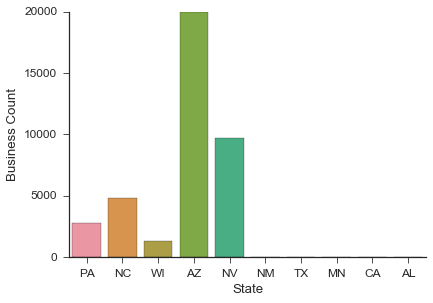

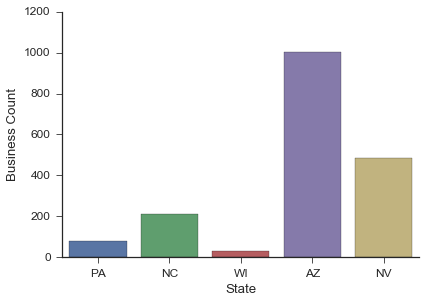

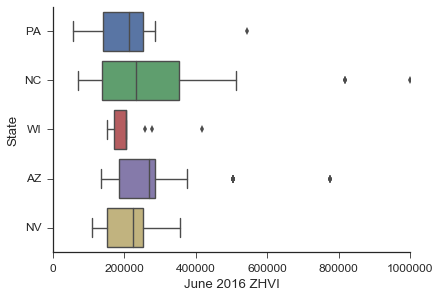

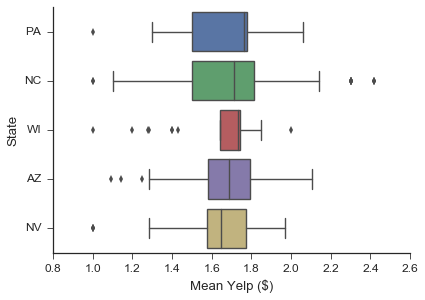

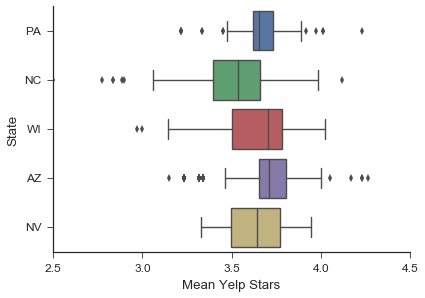

In [6]:
#total dataset
plt.figure()
sns.countplot(data = b, x = 'state')
plt.xlabel('State')
plt.ylabel('Business Count')
sns.despine()

#matched and filtered
plt.figure()
sns.countplot(data = bs, x = 'state_y')
plt.xlabel('State')
plt.ylabel('Business Count')
sns.despine()

#matched and filtered
plt.figure()
sns.boxplot(data = bs, x = 'latest_zhvi', y = 'state_y')
plt.ylabel('State')
plt.xlabel('June 2016 ZHVI')
sns.despine()

#matched and filtered
plt.figure()
sns.boxplot(data = bs, x = 'mean_price', y = 'state_y')
plt.ylabel('State')
plt.xlabel('Mean Yelp ($)')
sns.despine()

#matched and filtered
plt.figure()
sns.boxplot(data = bs, x = 'mean_stars', y = 'state_y')
plt.ylabel('State')
plt.xlabel('Mean Yelp Stars')
sns.despine()

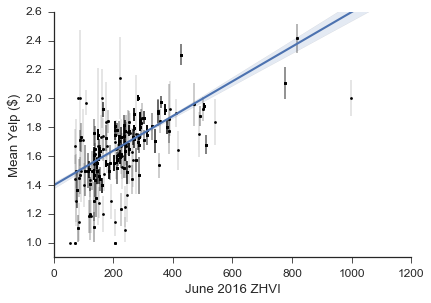

In [30]:
plt.figure()
plt.errorbar(bs['latest_zhvi']/1000.0, bs['mean_price'], bs['mean_price_err'], fmt = 'k.', lw = 0.2)
sns.regplot(bs['latest_zhvi']/1000.0, bs['mean_price'], bs['mean_price_err'], scatter_kws = {'s': 0})
plt.xlabel('June 2016 ZHVI')
plt.ylabel('Mean Yelp ($)')
plt.ylim(0.9,2.6)
#plt.colorbar(label = 'Number of Businesses in Neighborhood')
sns.despine()

In [244]:
ci = 0 #chain index
rsc = rs[(rs['name_x'] == tc[0])]

def MakeFracs(rsc):
    fracs = defaultdict(list) #initialize empty dictionary to store fraction informaion

    for zhvi in pd.Series(np.unique(rsc['latest_zhvi'])).dropna(): #for every non-na zhvi
        
        ss = rsc[(rsc['latest_zhvi'] == zhvi)] #subset by zhvi
        
        for i in range(1,6): #for stars in [1,2,3,4,5]
            fracs[int(zhvi)].append(float(len(ss[(ss['stars_x'] == i)])/len(ss))) # compute fraction of reviews with star i over total
    
        fracs[int(zhvi)].append(len(ss)) #append the total number of reviews in zhvi
    
    fracs_df = pd.DataFrame(fracs).T #create the dataframe, reset the index, and rename the columns
    fracs_df.reset_index(level=0, inplace=True)
    fracs_df.rename(columns = {'index': 'zhvi',\
                              0:1, 1:2, 2:3, 3:4, 4:5, 5:'n'}, inplace = True)

    #compute polarization metric
    fracs_df['polarization'] = (fracs_df[1] + fracs_df[5])/(fracs_df[1] + fracs_df[2] + fracs_df[3] + fracs_df[4])
    
    return fracs_df

def FracWLS(fracs_df, star):

    X = fracs_df['zhvi']
    X = sm.add_constant(X)
    y = fracs_df[star]
    w = fracs_df['n']

    lin = sm.WLS(y, X, weights = fracs_df['n']).fit()

    return lin

In [246]:
FracWLS(MakeFracs(rsc), 3).summary()

w_line = np.hstack((lin.pvalues.zhvi,\
                   lin.pvalues.const,\
                   lin.params.zhvi,\
                   lin.params.const))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      3   R-squared:                       0.018
Model:                            WLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.194
Date:                Sat, 29 Oct 2016   Prob (F-statistic):              0.278
Time:                        12:54:59   Log-Likelihood:                 61.709
No. Observations:                  69   AIC:                            -119.4
Df Residuals:                      67   BIC:                            -114.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1573      0.023      6.897      0.000         0.112     0.203
zhvi        8.578e-08   7.85e-08      1.093      0.278     -7.09e-08  2.42e-07
==============================================================================
Omnibus:                        4.260   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.119   Jarque-Bera (JB):                4.218
Skew:                           0.587   Prob(JB):                        0.121
Kurtosis:                       2.699   Cond. No.                     7.07e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.07e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
weights = [] #list of points by weight

for i in range(len(fracs_df)): #for each row in the fractional dataframe
    for j in range(int(fracs_df['n'][i])): #reproduce the points n times in a new dataframe
        weights.append([fracs_df['zhvi'][i],fracs_df[1][i],fracs_df[2][i],fracs_df[3][i],fracs_df[4][i],fracs_df[5][i]])
        
w_df = pd.DataFrame(weights) #convert back into a dataframe
w_df.rename(columns = {0: 'zhvi'}, inplace = True) #rename column 0 to zhvi

plt.scatter(w_df['zhvi'], w_df[1])

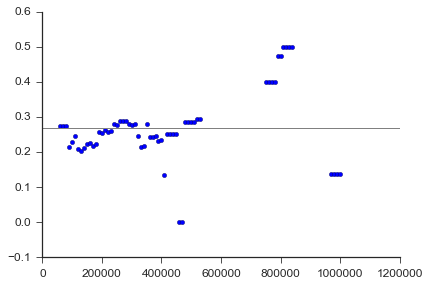

In [161]:
zhvi_bin_centers = np.linspace(0,1000000,101)
bin_eps = 30000

star = 5
rolling = []

for bc in zhvi_bin_centers:
    inbin = w_df[(w_df['zhvi'] < (bc + bin_eps)) & (w_df['zhvi'] > (bc - bin_eps))]
    
    if len(inbin) > 0:
        rolling.append((int(bc), np.mean(inbin[star])))
        
r_df = pd.DataFrame(rolling) #rolling average dataframe
ts = np.mean(abs(r_df[1] - np.mean(r_df[1]))) #area test statistic 

plt.scatter(r_df[0],r_df[1])
#plt.xlim(0,600000)
plt.axhline(np.mean(r_df[1]), lw = 1, c = 'grey')
sns.despine()

In [156]:
print(ts)

0.136177840647


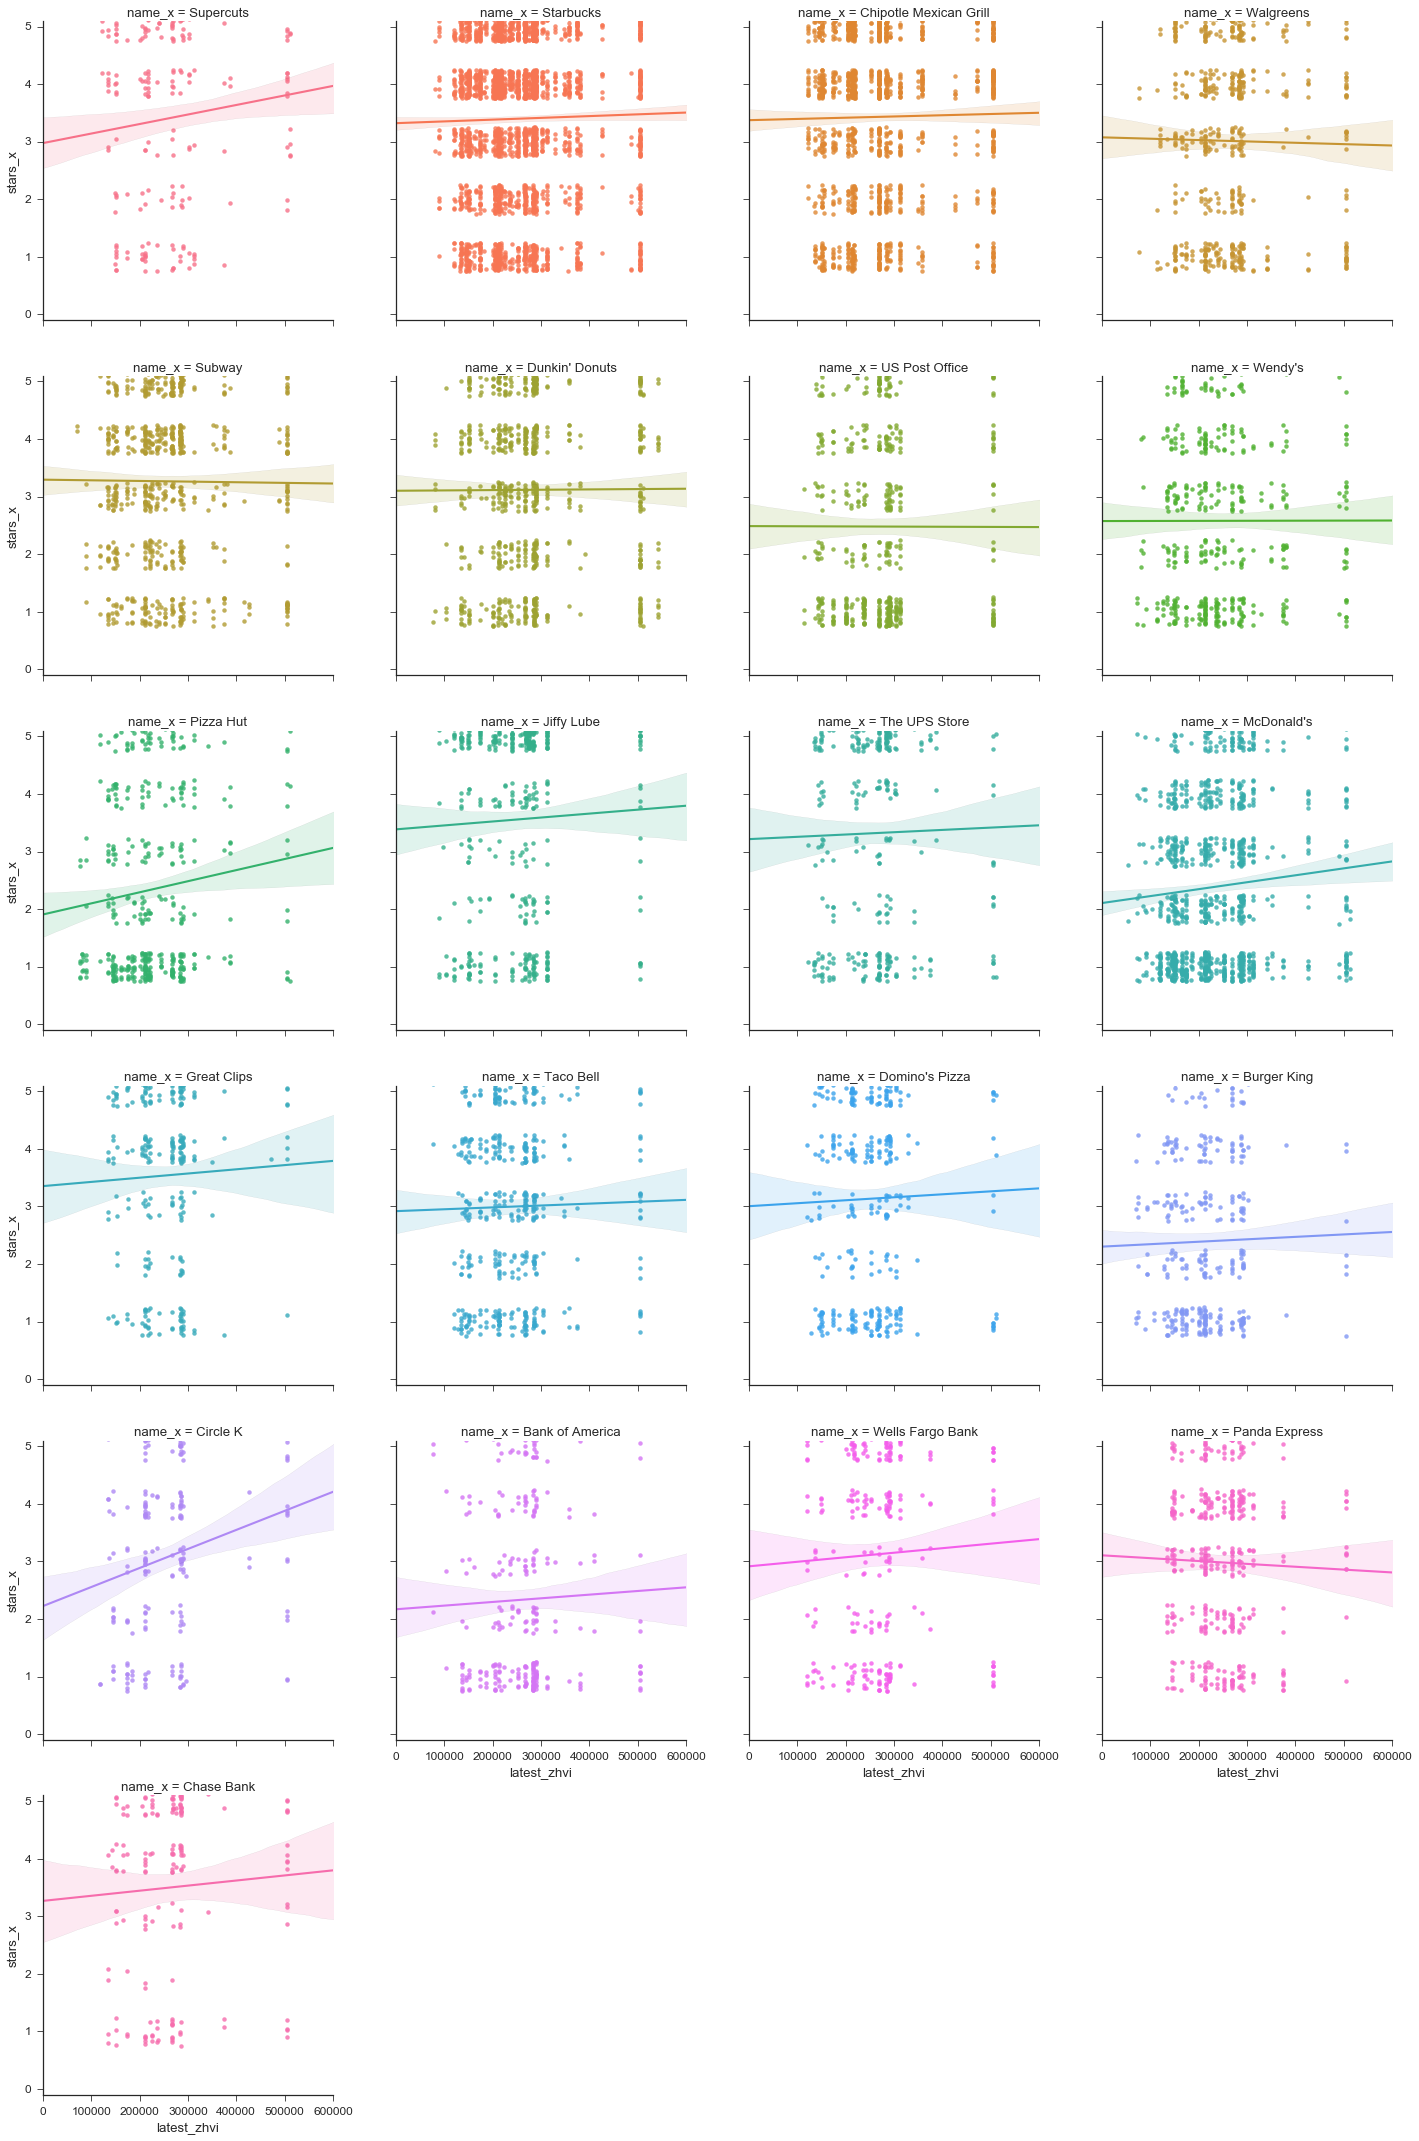

In [121]:
sns.lmplot(x = 'latest_zhvi', y = 'stars_x', col = 'name_x', hue = 'name_x', y_jitter = 0.25,  col_wrap = 4, data = rs)
plt.ylim(-0.1,5.1)
plt.xlim(0,600000)
sns.despine()
#plt.savefig('example_chain_regressions.png', dpi = 300, fmt = 'png')

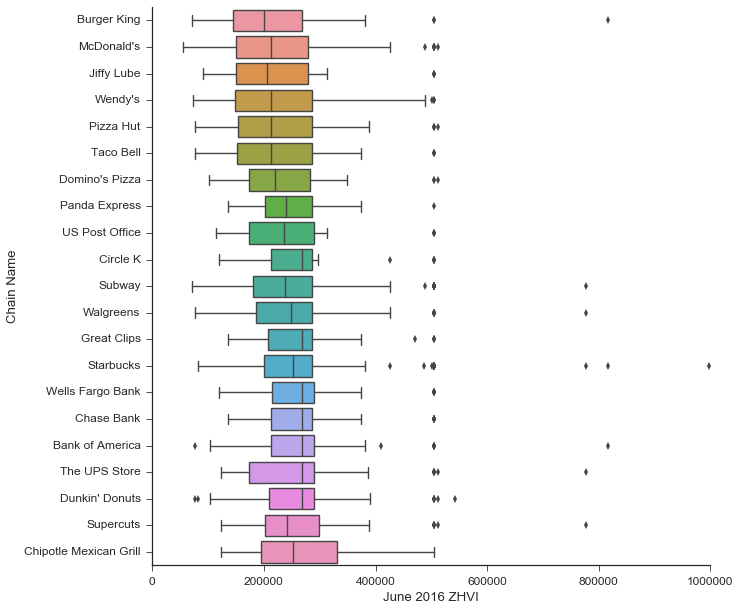

In [27]:
pylab.rcParams['figure.figsize'] = (10.0, 10.0) #set figure parameters
sns.boxplot(data = bs, x = 'latest_zhvi', y = 'name', order = OrderName(bs, 'name', 'latest_zhvi'))
plt.xlabel('June 2016 ZHVI')
plt.ylabel('Chain Name')
sns.despine()
#plt.savefig('rich_and_poor_chains.png', dpi = 300, fmt = 'png')

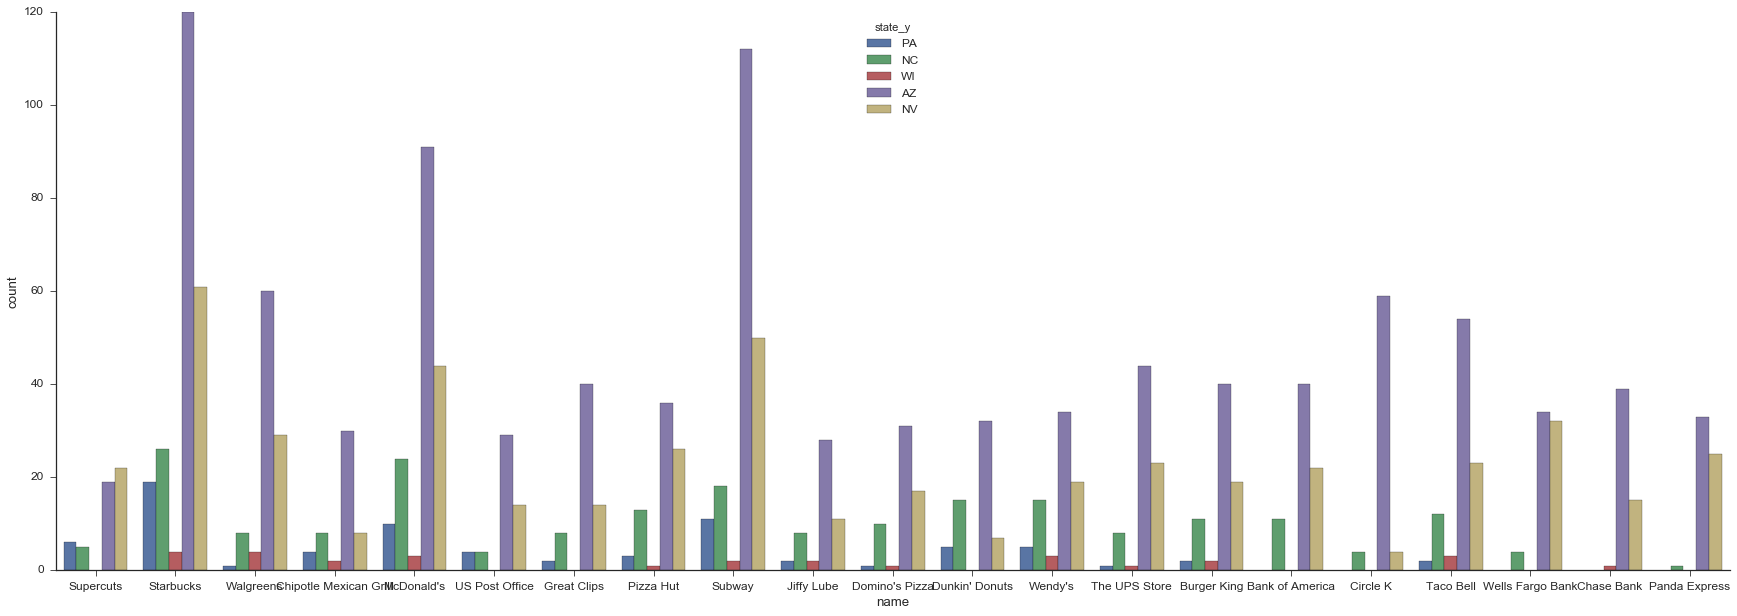

In [29]:
pylab.rcParams['figure.figsize'] = (30.0, 10.0) #set figure parameters
sns.countplot(data = bs, x = 'name', hue = 'state_y')
sns.despine()